In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [35]:
direction = 0
noise = 0.001

In [36]:
dataset = ThermDataset(fp='combined_data.xlsx', direction=direction, noise_scale=noise)

In [37]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [38]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [39]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 60)
        self.lin2 = nn.Linear(60, 60)
        self.lin3 = nn.Linear(60, 30)
        self.lin_fin = nn.Linear(30, output_size)


    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [40]:
n_samples = len(train_dataset)
_, input_size = dataset.x.shape
_, output_size = dataset.y.shape

model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [41]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)

# Training Loop

In [42]:
num_epochs = 100
loss_list = []
best_loss = np.inf
best_epoch = 0

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # forward pass and loss
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

    loss_list.append(loss.item())

    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch+1

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

print(f'\nbest loss: {best_loss:.2f} in epoch: {best_epoch}')

epoch: 10, loss = 183.6108
epoch: 20, loss = 189.3952
epoch: 30, loss = 145.9548
epoch: 40, loss = 202.5492
epoch: 50, loss = 197.4207
epoch: 60, loss = 183.9881
epoch: 70, loss = 194.8539
epoch: 80, loss = 183.6176
epoch: 90, loss = 179.6376
epoch: 100, loss = 161.0112

best loss: 131.79 in epoch: 86


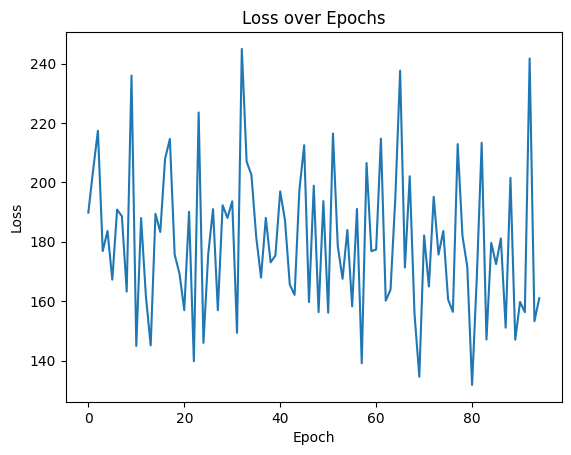

In [43]:
plt.plot(loss_list[5:])

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Testing

In [51]:
import matplotlib.pyplot as plt

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual.columns, actual_np, label='actual')
    plt.plot(actual.columns, pred_np, 'r+', label='predicted')

    if 0:
        plt.title("Temperature to Spectrum")
        plt.xlabel("Wavlength")
        plt.ylabel("Intensity")
    else:
        plt.title("Spectrum to Temperature")
        plt.xlabel("Layer")
        plt.ylabel("Temperature (K)")

    plt.legend()
    plt.show()

In [52]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        inputs = X_batch
        actual = y_batch

        pred = model(inputs)
        loss = criterion(pred, actual)
        total_loss += loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1

        if current_batch % int(total_batches/10) == 0:
            plot_actual_vs_pred(pred.as, actual, 0) 

average_loss = total_loss/n_samples
print(f"average loss: {average_loss}")

AttributeError: 'Tensor' object has no attribute 'columns'